# Replicating ResNet as done in Nakkirran et al. to reproduce double descent

In [ ]:
# Let's import the necessary libraries
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import TensorDataset, Subset, DataLoader, Dataset
from torchvision import datasets, transforms

/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Let's define all the hyperparameters
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = False
on_colab = False
model_width = 64
num_classes = 10
noise_levels = [0.10, 0.15, 0.20]
batch_size = 128
lr = 0.0001
epochs = 2000
model_seed = 42
data_seed = 42

In [ ]:
'''if on_colab == True:
    from google.colab import drive
    drive.mount('/conten/gdrive')'''

"if on_colab == True:\n    from google.colab import drive\n    drive.mount('/conten/gdrive')"

In [ ]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                          nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.bn1(x)
        out = self.relu(out)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, init_channels):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.avpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [ ]:
# Let's also import the standard resnet from PyTorch
resnet_pytorch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /Users/sienkadounia/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sienkadounia/anaconda3/envs/training/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#We need to put the number of classes in the output layer of the PyTorch layer to macth our number of classes 10
resnet_pytorch.fc = nn.Linear(512, num_classes)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(resnet_pytorch.parameters)
print(f"The number of parameters is: {count_parameters(resnet_pytorch)}")

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor()]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Preparing the indices to add label noise and cross-check
num_affected_labels_per_level = []
for i in noise_levels:
    num_noise = int(i * len(trainloader.dataset.data)) # total number of samples to be affected with current noise level
    num_affected_labels_per_level.append(num_noise)
    print(f'For {i} noise level, the total number of noisy labels is: {num_noise}')

For 0.1 noise level, the total number of noisy labels is: 5000
For 0.15 noise level, the total number of noisy labels is: 7500
For 0.2 noise level, the total number of noisy labels is: 10000


In [ ]:
all_corrupt_indices = []
affected_labels_per_level = []
all_check_labels = []
level_paths = ['label_noise/ten_percent_label_noise.csv', 'label_noise/fifteen_percent_label_noise.csv', 'label_noise/twenty_percent_label_noise.csv']
for i in range(len(noise_levels)):
    true_targets = trainloader.dataset.targets
    labels = copy.deepcopy(np.array(true_targets))
    np.random.seed(data_seed)
    corrupt_indices = np.random.permutation(len(true_targets))[:num_affected_labels_per_level[i]]
    all_corrupt_indices.append(corrupt_indices)
    check_labels = labels[corrupt_indices].tolist()
    all_check_labels.append(check_labels)
    loaded_labels = pd.read_csv(level_paths[i]).values
    loaded_labels = loaded_labels.squeeze()
    labels[corrupt_indices]= np.array(loaded_labels)
    affected_labels_per_level.append(labels[corrupt_indices])

In [ ]:
for i in range(len(noise_levels)):
    print(np.where(affected_labels_per_level[i]) == np.array(all_check_labels[i])) # cross-checking if there are any label that mistakenly came right again for 10% label noise
    print(f'Unique values for noisy labels are: {np.unique(np.array(affected_labels_per_level[i]), return_counts = True)}, and unique values for original labels are: {np.unique(np.array(check_labels[i]))}')

False
Unique values for noisy labels are: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([476, 487, 527, 523, 486, 504, 485, 509, 503, 500])), and unique values for original labels are: [7]
False
Unique values for noisy labels are: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([721, 734, 769, 768, 704, 763, 749, 755, 771, 766])), and unique values for original labels are: [8]
False
Unique values for noisy labels are: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 973,  979, 1030, 1023,  933, 1015,  996,  994, 1017, 1040])), and unique values for original labels are: [0]


/var/folders/z1/4ncpvz_901x1gm_4cv8jlcwr0000gn/T/ipykernel_59959/1516992163.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.where(affected_labels_per_level[i]) == np.array(all_check_labels[i])) # cross-checking if there are any label that mistakenly came right again for 10% label noise


In [ ]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sienka. Use `wandb login --relogin` to force relogin


True

In [ ]:
to_save = list(range(0, 135)) + list(range(130, 1000, 10))+ list(range(1000, 2000, 100)) + [1999]
for i in range(len(noise_levels)):
    if model_seed is not None:
        torch.manual_seed(model_seed)
        model = make_resnet18k(model_width, num_classes)
        model.to(device)
    if use_label_noise:
        true_targets = trainloader.dataset.targets
        labels = copy.deepcopy(np.array(true_targets))
        labels[all_corrupt_indices[i]] = affected_labels_per_level[i]
        trainloader.dataset.targets = labels.tolist()
        dl = trainloader

    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
    print(f"Started training model with noise level {noise_levels[i]}")

    wandb.init(project="SLT of Double Descent", 
    config = {'epochs': epochs,'classes': num_classes,
                    'learning_rate': lr,
                    'use_label_noise': use_label_noise,
                    'noise_level': noise_levels[i],
                    'dataset': "CIFAR10",
                    'architecture': "ResNet18",
                    'pytorch_resnet_model': pytorch_default_resnet,
                    'model_width': model_width,
                    'augmented': augmented,
                    'adam optimizer': use_adam_op})

    wandb.watch(model)
    config = wandb.config

    test_losses = []
    train_losses = []
    train_accs = []
    test_accs = []

    step = 0
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_acc = 0.0
        
        for j, data in enumerate(dl):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            batch_loss = criterion(outputs, labels)

            predictions = outputs.argmax(axis=-1)
            train_acc += torch.sum(predictions == labels).item()
            train_loss += batch_loss.item()

            batch_loss.backward()
            optimizer.step()

            step += 1

            wandb.log({'batch_loss': batch_loss.item()}, step=step)

        # Calculate average training loss for the epoch
        train_loss /= len(trainloader)
        train_acc /= len(trainloader.dataset.data)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation (or test) loop
        model.eval()

        test_loss = 0.0
        test_acc = 0.0

        with torch.no_grad():
            for k, test_data in enumerate(testloader):
                test_images, test_labels = test_data
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                outputs = model(test_images)
                batch_test_loss = criterion(outputs, test_labels)
                test_loss += batch_test_loss.item()

                predictions = outputs.argmax(axis=-1)
                test_acc += torch.sum(predictions == test_labels).item()

        # Let's calculate average test loss for the epoch
        test_loss /= len(testloader)
        test_acc /= len(testloader.dataset.data)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        wandb.log({'epoch': epoch,
                    'loss/train': train_loss,
                    'loss/test': test_loss,
                    'accuracy/train': train_acc,
                    'accuracy/test': test_acc
                }, step=step)


        # Print or log the training and test losses for each epoch
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        if epoch in to_save:
            checkpoint = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optim_state': optimizer.state_dict()
            }

            prefix = 'noise_' + str(int(100 * noise_levels[i])) + 'checkpoint' if not use_label_noise else 'noise_' + str(int(100 * noise_levels[i])) + 'checkpoint-with-noise'
            FILENAME = prefix + str(epoch)+'.pth'
            Path = f'/content/gdrive/My Drive/{FILENAME}'
            torch.save(checkpoint, '/Users/sienkadounia/lab/ai-futures/Project/ewdd/'+FILENAME) if not on_colab else torch.save(checkpoint, Path)

    trl = np.array(train_losses)
    tel = np.array(test_losses)
    trac = np.array(train_accs)
    teac = np.array(test_accs)
    trl = pd.DataFrame(trl)
    tel = pd.DataFrame(tel)
    teac = pd.DataFrame(teac)
    trac = pd.DataFrame(trac)
    trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "train_losses_with_label_noise.csv", index=False)
    tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "test_losses_with_label_noise.csv", index=False)
    teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "test_accs_with_label_noise.csv", index=False)
    trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_train_accs.csv", index=False) if not use_label_noise else trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/'+ prefix + "train_accs_with_label_noise.csv", index=False)
    wandb.finish()
print('Finished taining models!')

Started training model with noise level 0.1


Epoch 1/2000, Train Loss: 1.8107, Test Loss: 1.4608
Epoch 2/2000, Train Loss: 1.5830, Test Loss: 1.3144
Epoch 3/2000, Train Loss: 1.4878, Test Loss: 1.2029
Epoch 4/2000, Train Loss: 1.4136, Test Loss: 1.1452
Epoch 5/2000, Train Loss: 1.3587, Test Loss: 1.1047
Epoch 6/2000, Train Loss: 1.3096, Test Loss: 1.0466
Epoch 7/2000, Train Loss: 1.2675, Test Loss: 1.0168
Epoch 8/2000, Train Loss: 1.2400, Test Loss: 0.9967
Epoch 9/2000, Train Loss: 1.2094, Test Loss: 0.9498
Epoch 10/2000, Train Loss: 1.1786, Test Loss: 0.9292
Epoch 11/2000, Train Loss: 1.1536, Test Loss: 0.9081
Epoch 12/2000, Train Loss: 1.1350, Test Loss: 0.8919
Epoch 13/2000, Train Loss: 1.1111, Test Loss: 0.9063
Epoch 14/2000, Train Loss: 1.0939, Test Loss: 0.8806
Epoch 15/2000, Train Loss: 1.0743, Test Loss: 0.8657
Epoch 16/2000, Train Loss: 1.0556, Test Loss: 0.8492
Epoch 17/2000, Train Loss: 1.0408, Test Loss: 0.8258
Epoch 18/2000, Train Loss: 1.0262, Test Loss: 0.8272
Epoch 19/2000, Train Loss: 1.0096, Test Loss: 0.8066
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁▅▆▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████▇█▇█▇▇█▇▇
accuracy/train,▁▅▇▇▇███████████████████████████████████
batch_loss,█▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇██▇█▇▇████
loss/train,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7562
accuracy/train,0.99864
batch_loss,0.00145
epoch,1999
loss/test,2.03465


Started training model with noise level 0.15


Epoch 1/2000, Train Loss: 1.8940, Test Loss: 1.4998
Epoch 2/2000, Train Loss: 1.6928, Test Loss: 1.3744
Epoch 3/2000, Train Loss: 1.6095, Test Loss: 1.2429
Epoch 4/2000, Train Loss: 1.5450, Test Loss: 1.1788
Epoch 5/2000, Train Loss: 1.4963, Test Loss: 1.1425
Epoch 6/2000, Train Loss: 1.4490, Test Loss: 1.1143
Epoch 7/2000, Train Loss: 1.4086, Test Loss: 1.0630
Epoch 8/2000, Train Loss: 1.3834, Test Loss: 1.0506
Epoch 9/2000, Train Loss: 1.3570, Test Loss: 1.0140
Epoch 10/2000, Train Loss: 1.3285, Test Loss: 0.9803
Epoch 11/2000, Train Loss: 1.3088, Test Loss: 0.9462
Epoch 12/2000, Train Loss: 1.2869, Test Loss: 0.9506
Epoch 13/2000, Train Loss: 1.2663, Test Loss: 0.9554
Epoch 14/2000, Train Loss: 1.2473, Test Loss: 0.9363
Epoch 15/2000, Train Loss: 1.2278, Test Loss: 0.8966
Epoch 16/2000, Train Loss: 1.2138, Test Loss: 0.9005
Epoch 17/2000, Train Loss: 1.2014, Test Loss: 0.8739
Epoch 18/2000, Train Loss: 1.1878, Test Loss: 0.8760
Epoch 19/2000, Train Loss: 1.1697, Test Loss: 0.8766
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▂█▁▃▆▄▇▅▆▆▆▇▆▇▆▆▆█▇▆▅█▇▆▇▇▇▆▇▇▇▇█▇▇▇█▆▇█
accuracy/train,▁▅▇▇▇███████████████████████████████████
batch_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▁▃▄▄▅▅▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██▇██▇
loss/train,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7315
accuracy/train,0.99814
batch_loss,6e-05
epoch,1999
loss/test,2.18828


Started training model with noise level 0.2


Epoch 1/2000, Train Loss: 1.9653, Test Loss: 1.5374
Epoch 2/2000, Train Loss: 1.7900, Test Loss: 1.4225
Epoch 3/2000, Train Loss: 1.7169, Test Loss: 1.3278
Epoch 4/2000, Train Loss: 1.6590, Test Loss: 1.2366
Epoch 5/2000, Train Loss: 1.6166, Test Loss: 1.2099
Epoch 6/2000, Train Loss: 1.5730, Test Loss: 1.1621
Epoch 7/2000, Train Loss: 1.5375, Test Loss: 1.1136
Epoch 8/2000, Train Loss: 1.5141, Test Loss: 1.0982
Epoch 9/2000, Train Loss: 1.4885, Test Loss: 1.0650
Epoch 10/2000, Train Loss: 1.4639, Test Loss: 1.0371
Epoch 11/2000, Train Loss: 1.4471, Test Loss: 1.0089
Epoch 12/2000, Train Loss: 1.4257, Test Loss: 1.0171
Epoch 13/2000, Train Loss: 1.4092, Test Loss: 1.0147
Epoch 14/2000, Train Loss: 1.3922, Test Loss: 0.9937
Epoch 15/2000, Train Loss: 1.3754, Test Loss: 0.9557
Epoch 16/2000, Train Loss: 1.3610, Test Loss: 0.9586
Epoch 17/2000, Train Loss: 1.3460, Test Loss: 0.9154
Epoch 18/2000, Train Loss: 1.3324, Test Loss: 0.9297
Epoch 19/2000, Train Loss: 1.3169, Test Loss: 0.9344
Ep

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▇█▁▄▄▅▅▆▄▅▆▆▆▆▆▆▆▇▄▅▆▆▄▆▆▅▆▆▆▄▅▇▇▆▅▇▇▆▇▆
accuracy/train,▁▄▇▇▇███████████████████████████████████
batch_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss/test,▁▁▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇█▇████████
loss/train,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy/test,0.7008
accuracy/train,0.99808
batch_loss,0.02666
epoch,1999
loss/test,2.45945


Finished taining models!


In [ ]:
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 1.5
some_multiplier_2 = 1.5

In [ ]:
ewdd_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/ewdd_metrics.csv')

In [ ]:
model_names = ['10% label noise - accuracy/test', '15% label noise - accuracy/test', '20% label noise - accuracy/test']
df = []
for i in model_names:
  df.append(ewdd_metrics[i])
#df = pd.DataFrame(df)

In [ ]:
df = df.transpose()

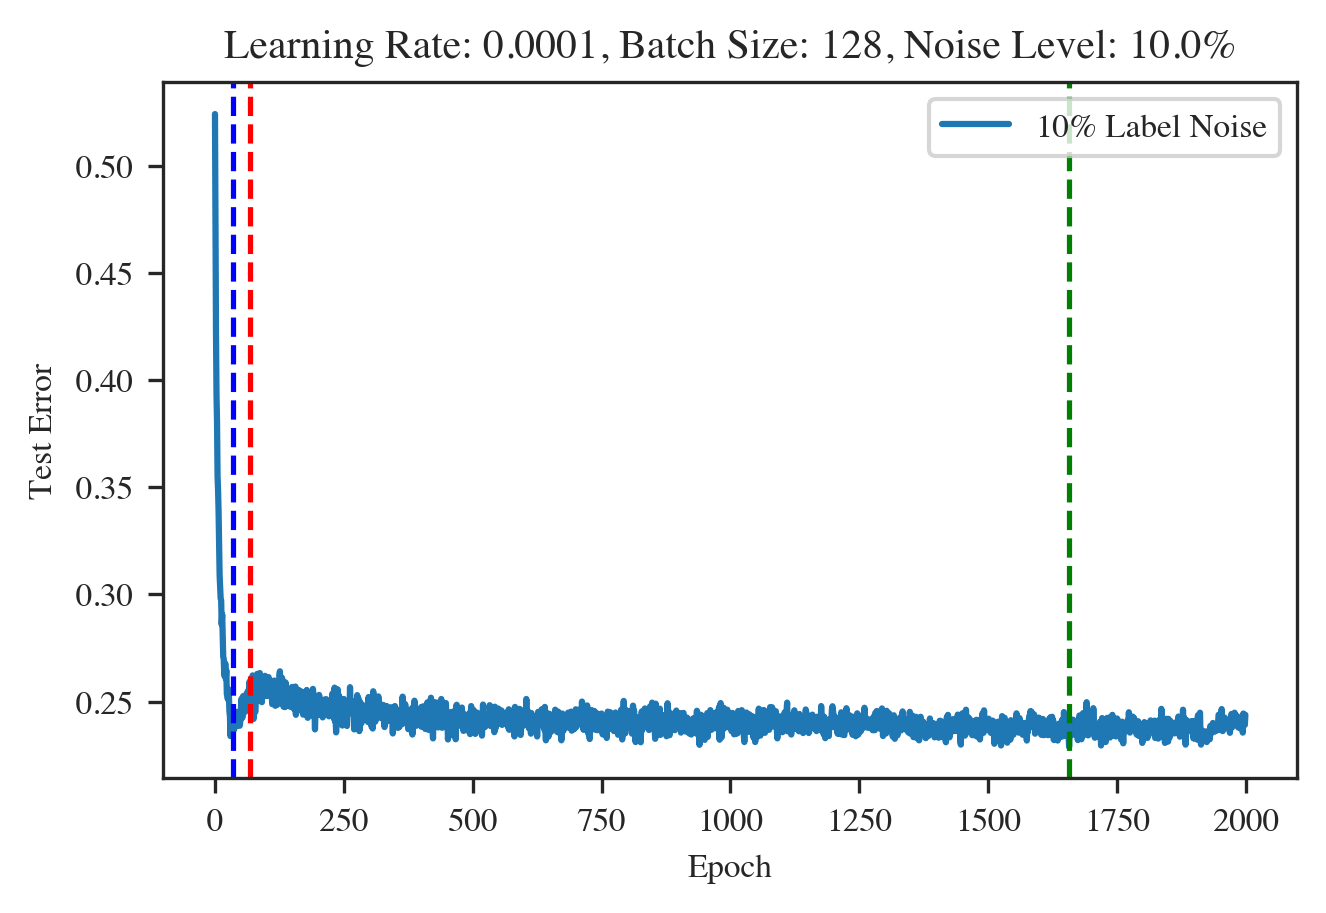

In [ ]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))

epochs = list(range(0, 2000))
plt.plot(epochs, 1-df[model_names[0]])
min_index = np.argmax(df[model_names[0]])
before =(df[model_names[0]][min_index:])
rest =(df[model_names[0]][min_index:-1])
min_index_1 = np.argmin(before)
max_index = np.argmin(rest)+ min_index_1
plt.axvline(x=min_index, color='green', linestyle='--', linewidth = 1.25)
plt.axvline(x=min_index_1, color='blue', linestyle='--', linewidth = 1.25)
plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title(f'Learning Rate: {lr}, Batch Size: {batch_size}, Noise Level: {100*noise_levels[0]}%')
plt.legend(["10% Label Noise"], loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig("ten_percent_losses.pdf")
plt.show()

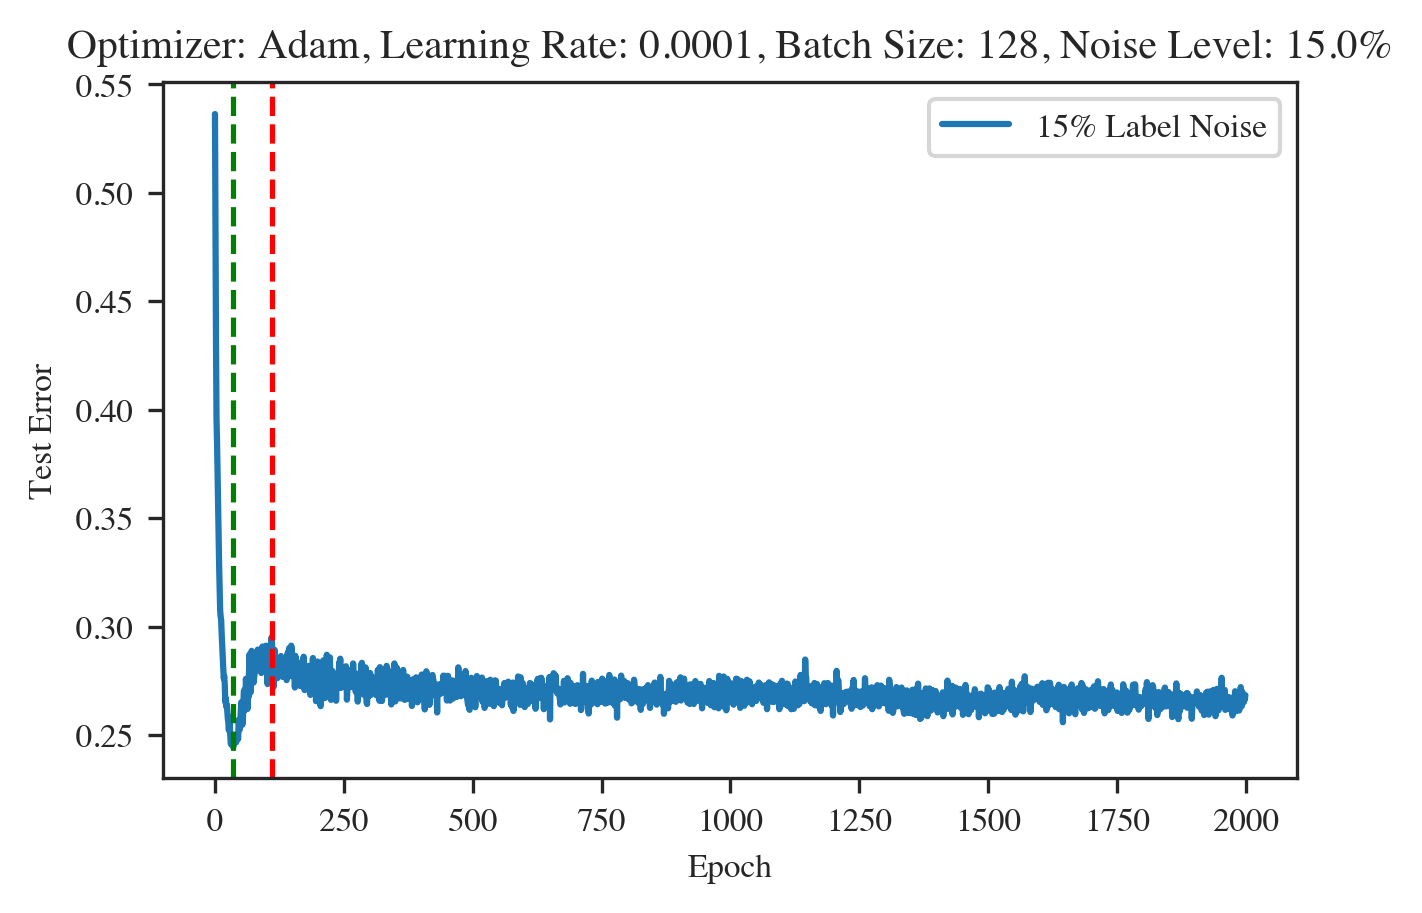

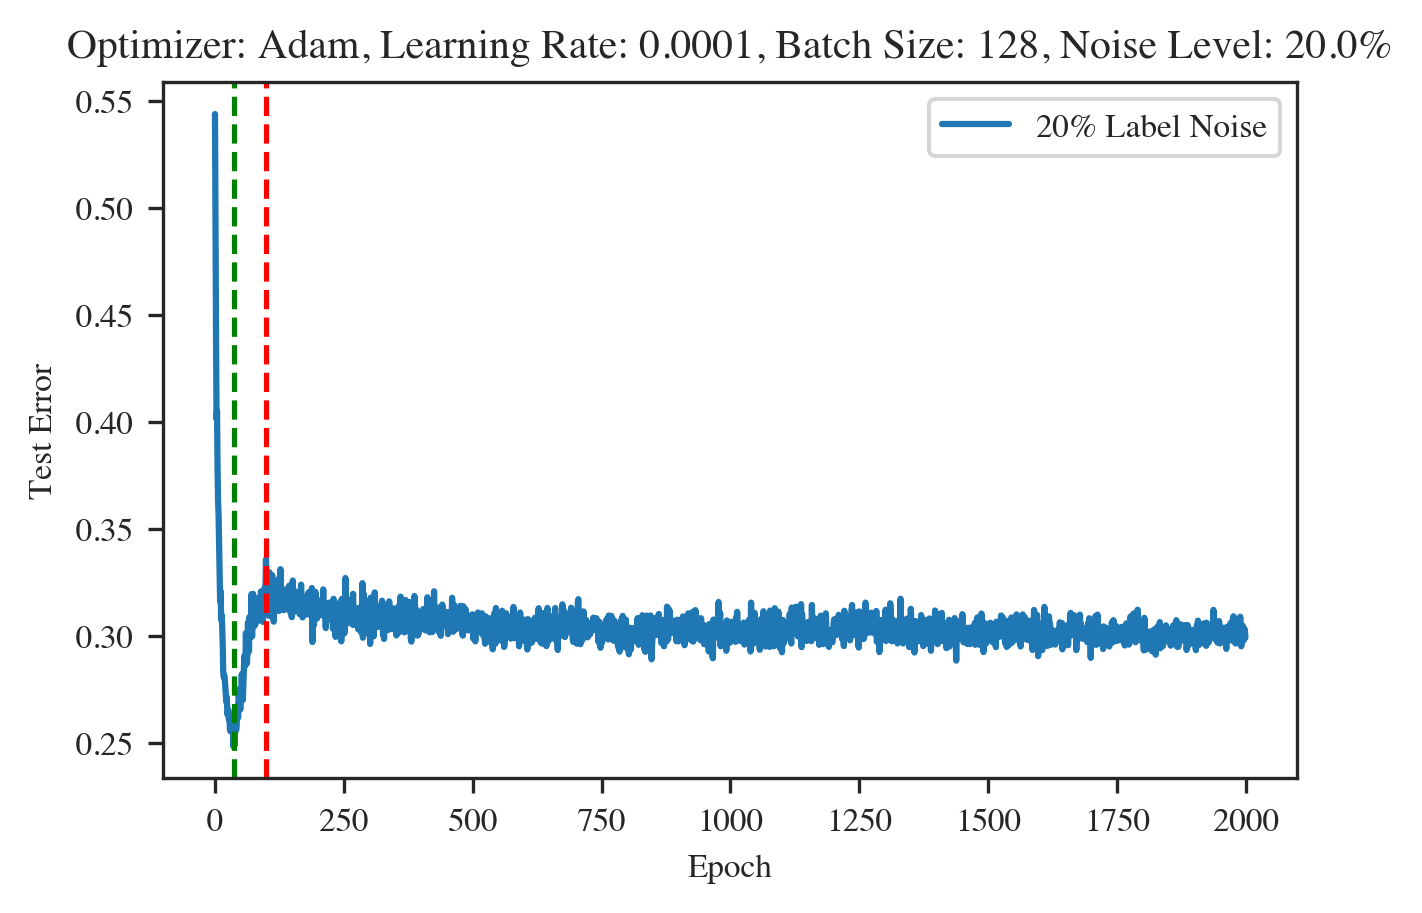

In [ ]:
epochs = list(range(0, 2000))
optimi = 'SGD' if not use_adam_op else 'Adam'
for i in range(1, len(noise_levels)):
    plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
    plt.plot(epochs, 1-df[model_names[i]])
    min_index = np.argmin(1-df[model_names[i]])
    rest =(1-df[model_names[i]])[min_index:]
    max_index = min_index + np.argmax(rest)
    plt.axvline(x=min_index, color='green', linestyle='--', linewidth = 1.25)
    plt.axvline(x=max_index, color='red', linestyle='--', linewidth = 1.25)
    plt.xlabel('Epoch')
    plt.ylabel('Test Error')
    plt.title(f'Optimizer: {optimi}, Learning Rate: {lr}, Batch Size: {batch_size}, Noise Level: {100*noise_levels[i]}%')
    plt.legend([f"{str(int(100*noise_levels[i]))}% Label Noise"], loc="upper right")
    seaborn.set_style("ticks")
    plt.rcParams["font.family"] = "Times"
    plt.rcParams['figure.dpi'] = 300
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.rc('axes', labelsize=8)
    plt.rc('legend', fontsize=8)
    plt.rc('axes', titlesize=10)
    plt.savefig(str(int(100*noise_levels[i]))+"_percent_losses.pdf")
    plt.show()

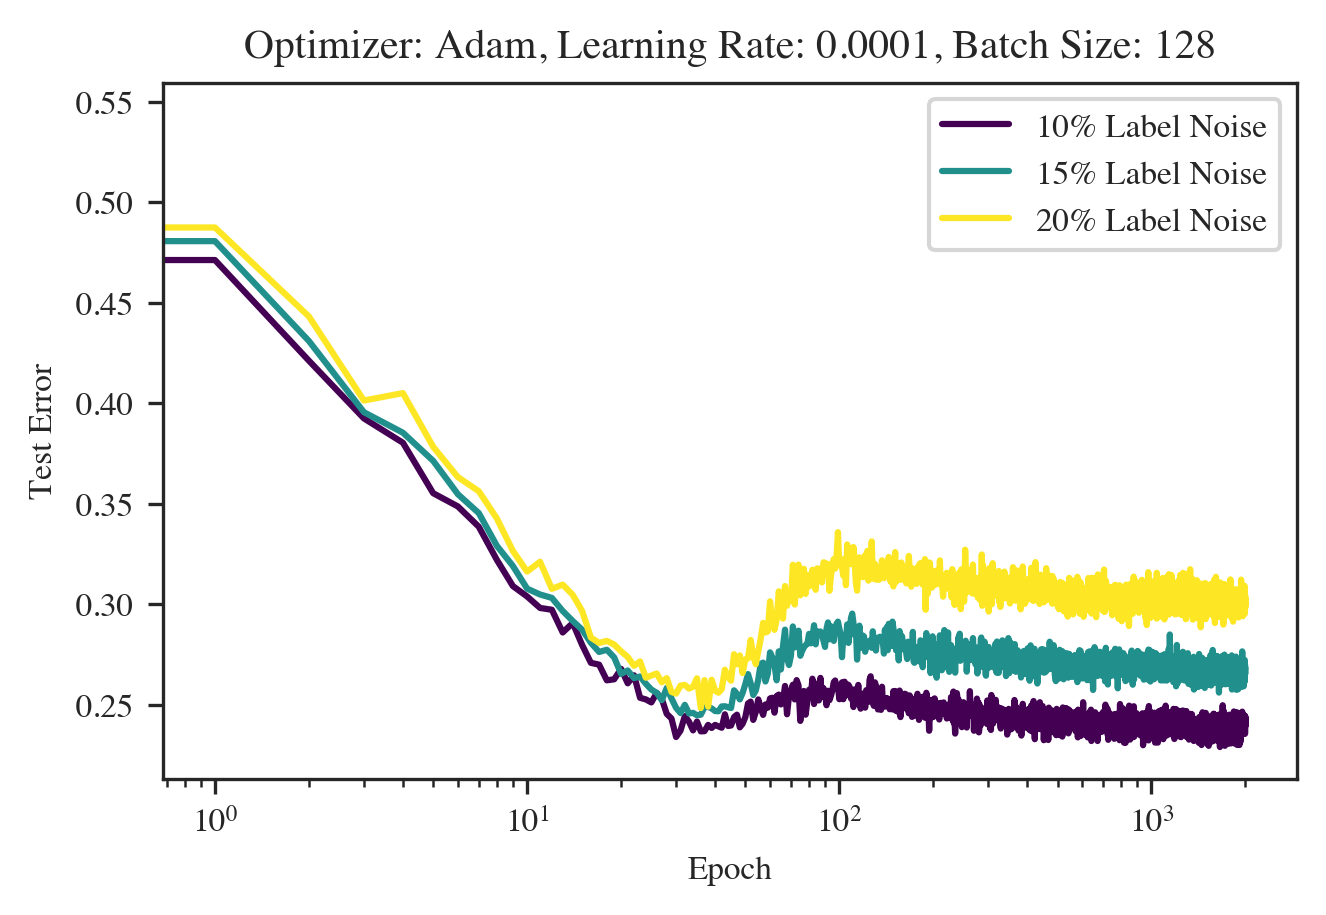

In [ ]:
plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(min(noise_levels), max(noise_levels))
epochs = list(range(0, 2000))
for noise, error in zip(noise_levels, df):
    plt.plot(epochs, 1-error, color=cmap(norm(noise)))
#plt.plot(epochs, 1-df[model_names[1]])
#plt.plot(epochs, 1-df[model_names[2]])
plt.xlabel('Epoch')
plt.xscale('log')
plt.ylabel('Test Error')
plt.set_cmap('viridis')
plt.title(f'Optimizer: {optimi}, Learning Rate: {lr}, Batch Size: {batch_size}')
plt.legend(["10% Label Noise", "15% Label Noise", "20% Label Noise"], loc="upper right")
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.savefig("all_losses.pdf")
plt.show()

In [ ]:
# Preparing the indices to add label noise and cross-check
num_affected_test_labels_per_level = []
for i in noise_levels:
    num_noise = int(i * len(testloader.dataset.data)) # total number of samples to be affected with current noise level
    num_affected_test_labels_per_level.append(num_noise)
    print(f'For {i} noise level, the total number of noisy test labels is: {num_noise}')

For 0.1 noise level, the total number of noisy test labels is: 1000
For 0.15 noise level, the total number of noisy test labels is: 1500
For 0.2 noise level, the total number of noisy test labels is: 2000


In [ ]:
all_corrupt_test_indices = []
affected_test_labels_per_level = []
all_test_check_labels = []
test_level_paths = ['label_noise/test_ten_percent_label_noise.csv', 'label_noise/test_fifteen_percent_label_noise.csv', 'label_noise/test_twenty_percent_label_noise.csv']
for i in range(len(noise_levels)):
    true_test_targets = testloader.dataset.targets
    test_labels = copy.deepcopy(np.array(true_test_targets))
    np.random.seed(data_seed)
    corrupt_test_indices = np.random.permutation(len(true_test_targets))[:num_affected_test_labels_per_level[i]]
    all_corrupt_test_indices.append(corrupt_test_indices)
    test_check_labels = test_labels[corrupt_test_indices].tolist()
    all_test_check_labels.append(test_check_labels)
    loaded_test_labels = pd.read_csv(test_level_paths[i]).values
    loaded_test_labels = loaded_test_labels.squeeze()
    test_labels[corrupt_test_indices]= np.array(loaded_test_labels)
    affected_test_labels_per_level.append(test_labels[corrupt_test_indices])

In [ ]:
affected_test_labels_per_level

[array([6, 3, 2, 1, 6, 6, 1, 8, 9, 3, 6, 3, 9, 3, 1, 5, 0, 9, 8, 3, 7, 7,
        9, 4, 2, 9, 5, 2, 6, 1, 2, 4, 6, 0, 2, 0, 5, 9, 5, 1, 5, 3, 4, 8,
        2, 8, 8, 1, 5, 2, 2, 5, 5, 2, 0, 3, 3, 9, 3, 4, 7, 4, 5, 5, 5, 3,
        9, 6, 1, 6, 7, 9, 8, 9, 9, 5, 8, 4, 7, 1, 9, 1, 8, 9, 3, 7, 8, 9,
        5, 0, 4, 8, 2, 2, 2, 0, 6, 7, 9, 1, 8, 3, 6, 9, 6, 0, 0, 5, 7, 1,
        0, 0, 5, 6, 7, 1, 8, 5, 7, 1, 1, 4, 2, 4, 9, 3, 6, 3, 3, 6, 2, 5,
        7, 3, 4, 7, 7, 4, 9, 3, 8, 3, 1, 9, 4, 5, 8, 8, 9, 6, 7, 7, 9, 6,
        0, 5, 2, 9, 0, 7, 8, 6, 0, 2, 4, 1, 1, 5, 2, 2, 7, 6, 7, 7, 6, 0,
        0, 7, 1, 8, 8, 6, 2, 4, 4, 0, 1, 1, 9, 0, 3, 9, 7, 9, 3, 8, 2, 2,
        6, 0, 6, 9, 7, 1, 3, 5, 3, 8, 3, 4, 7, 6, 4, 0, 1, 5, 6, 5, 7, 7,
        3, 8, 5, 9, 0, 8, 7, 9, 8, 7, 9, 6, 0, 7, 6, 3, 4, 6, 5, 8, 5, 2,
        2, 2, 4, 7, 3, 8, 7, 2, 0, 0, 6, 9, 6, 3, 0, 6, 3, 3, 7, 5, 4, 0,
        3, 4, 8, 4, 1, 1, 3, 2, 2, 6, 8, 6, 1, 6, 6, 0, 9, 3, 1, 3, 3, 2,
        3, 6, 1, 8, 1, 3, 9, 3, 3, 2, 

In [ ]:
use_test_label_noise = True
for i in range(len(noise_levels)):
    if model_seed is not None:
        torch.manual_seed(model_seed)
        model = make_resnet18k(model_width, num_classes)
        model.to(device)
    if use_test_label_noise:
        true_test_targets = testloader.dataset.targets
        test_labels = copy.deepcopy(np.array(true_test_targets))
        test_labels[all_corrupt_test_indices[i]] = affected_test_labels_per_level[i]
        testloader.dataset.targets = test_labels.tolist()
        dl = trainloader

    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
    #optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
    print(f"Started testing model with noise level {noise_levels[i]}")

    wandb.init(project="SLT of Double Descent", 
    config = {'epochs': epochs,'classes': num_classes,
                    'learning_rate': lr,
                    'use_label_noise': use_label_noise,
                    'use_test_label_noise': use_test_label_noise,
                    'noise_level': noise_levels[i],
                    'dataset': "CIFAR10",
                    'architecture': "ResNet18",
                    'pytorch_resnet_model': pytorch_default_resnet,
                    'model_width': model_width,
                    'augmented': augmented,
                    'adam optimizer': use_adam_op})

    wandb.watch(model)
    config = wandb.config

    test_losses = []
    #train_losses = []
    #train_accs = []
    test_accs = []

    step = 0
    for epoch in to_save:
        file_path = '/Volumes/New/slt_of_dd/ewdd/'
        selected_checkpoint = file_path + 'noise_' + str(int(100 * noise_levels[i])) + 'checkpoint-with-noise' + str(epoch)+'.pth'
        checkpoint = torch.load(selected_checkpoint)
        model.load_state_dict(checkpoint['model_state'])
        model.eval()

        test_loss = 0.0
        test_acc = 0.0

        with torch.no_grad():
            for k, test_data in enumerate(testloader):
                test_images, test_labels = test_data
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                outputs = model(test_images)
                batch_test_loss = criterion(outputs, test_labels)
                test_loss += batch_test_loss.item()

                predictions = outputs.argmax(axis=-1)
                test_acc += torch.sum(predictions == test_labels).item()

        # Let's calculate average test loss for the epoch
        test_loss /= len(testloader)
        test_acc /= len(testloader.dataset.data)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        wandb.log({'epoch': epoch,
                    'loss/test': test_loss,
                    'accuracy/test': test_acc
                }, step=step)


        # Print or log the training and test losses for each epoch
        print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
        
        prefix = 'noise_' + str(int(100 * noise_levels[i])) + 'checkpoint' if not use_label_noise else 'noise_' + str(int(100 * noise_levels[i])) + 'checkpoint-with-noise'


    #trl = np.array(train_losses)
    tel = np.array(test_losses)
    #trac = np.array(train_accs)
    teac = np.array(test_accs)
    trl = pd.DataFrame(trl)
    tel = pd.DataFrame(tel)
    teac = pd.DataFrame(teac)
    #trac = pd.DataFrame(trac)
    #trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "train_losses_with_label_noise.csv", index=False)
    tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "noisy_clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "noisy_test_losses_with_label_noise.csv", index=False)
    teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "noisy_clean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "noisy_test_accs_with_label_noise.csv", index=False)
    #trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/' + prefix + "clean_train_accs.csv", index=False) if not use_label_noise else trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/'+ prefix + "train_accs_with_label_noise.csv", index=False)
    wandb.finish()
print('Finished taining models!')

Started testing model with noise level 0.1


Epoch 1/2000, Test Loss: 1.6526, Accuracy: 0.4353
Epoch 2/2000, Test Loss: 1.5214, Accuracy: 0.4847
Epoch 3/2000, Test Loss: 1.4469, Accuracy: 0.5249
Epoch 4/2000, Test Loss: 1.3971, Accuracy: 0.5481
Epoch 5/2000, Test Loss: 1.3675, Accuracy: 0.5629
Epoch 6/2000, Test Loss: 1.3154, Accuracy: 0.5814
Epoch 7/2000, Test Loss: 1.3097, Accuracy: 0.5844
Epoch 8/2000, Test Loss: 1.2691, Accuracy: 0.6059
Epoch 9/2000, Test Loss: 1.2375, Accuracy: 0.6110
Epoch 10/2000, Test Loss: 1.2327, Accuracy: 0.6260
Epoch 11/2000, Test Loss: 1.2129, Accuracy: 0.6250
Epoch 12/2000, Test Loss: 1.2049, Accuracy: 0.6313
Epoch 13/2000, Test Loss: 1.1885, Accuracy: 0.6410
Epoch 14/2000, Test Loss: 1.1776, Accuracy: 0.6476
Epoch 15/2000, Test Loss: 1.1765, Accuracy: 0.6492
Epoch 16/2000, Test Loss: 1.1602, Accuracy: 0.6564
Epoch 17/2000, Test Loss: 1.1497, Accuracy: 0.6589
Epoch 18/2000, Test Loss: 1.1456, Accuracy: 0.6597
Epoch 19/2000, Test Loss: 1.1298, Accuracy: 0.6665
Epoch 20/2000, Test Loss: 1.1382, Accura

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁
epoch,▁
loss/test,▁
accuracy/test,0.6826
epoch,1999
loss/test,4.00483


Started testing model with noise level 0.15


Epoch 1/2000, Test Loss: 1.7570, Accuracy: 0.4004
Epoch 2/2000, Test Loss: 1.6418, Accuracy: 0.4507
Epoch 3/2000, Test Loss: 1.5772, Accuracy: 0.4932
Epoch 4/2000, Test Loss: 1.5182, Accuracy: 0.5176
Epoch 5/2000, Test Loss: 1.5000, Accuracy: 0.5250
Epoch 6/2000, Test Loss: 1.4630, Accuracy: 0.5409
Epoch 7/2000, Test Loss: 1.4417, Accuracy: 0.5520
Epoch 8/2000, Test Loss: 1.4260, Accuracy: 0.5650
Epoch 9/2000, Test Loss: 1.4017, Accuracy: 0.5700
Epoch 10/2000, Test Loss: 1.3818, Accuracy: 0.5834
Epoch 11/2000, Test Loss: 1.3598, Accuracy: 0.5897
Epoch 12/2000, Test Loss: 1.3624, Accuracy: 0.5950
Epoch 13/2000, Test Loss: 1.3387, Accuracy: 0.5999
Epoch 14/2000, Test Loss: 1.3358, Accuracy: 0.6030
Epoch 15/2000, Test Loss: 1.3167, Accuracy: 0.6132
Epoch 16/2000, Test Loss: 1.3159, Accuracy: 0.6195
Epoch 17/2000, Test Loss: 1.3136, Accuracy: 0.6169
Epoch 18/2000, Test Loss: 1.2966, Accuracy: 0.6199
Epoch 19/2000, Test Loss: 1.2952, Accuracy: 0.6248
Epoch 20/2000, Test Loss: 1.2956, Accura

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁
epoch,▁
loss/test,▁
accuracy/test,0.6208
epoch,1999
loss/test,4.92992


Started testing model with noise level 0.2


Epoch 1/2000, Test Loss: 1.8334, Accuracy: 0.3800
Epoch 2/2000, Test Loss: 1.7428, Accuracy: 0.4229
Epoch 3/2000, Test Loss: 1.6870, Accuracy: 0.4559
Epoch 4/2000, Test Loss: 1.6285, Accuracy: 0.4831
Epoch 5/2000, Test Loss: 1.6378, Accuracy: 0.4835
Epoch 6/2000, Test Loss: 1.5763, Accuracy: 0.5085
Epoch 7/2000, Test Loss: 1.5561, Accuracy: 0.5200
Epoch 8/2000, Test Loss: 1.5493, Accuracy: 0.5267
Epoch 9/2000, Test Loss: 1.5197, Accuracy: 0.5331
Epoch 10/2000, Test Loss: 1.5055, Accuracy: 0.5444
Epoch 11/2000, Test Loss: 1.4894, Accuracy: 0.5459
Epoch 12/2000, Test Loss: 1.5036, Accuracy: 0.5496
Epoch 13/2000, Test Loss: 1.4746, Accuracy: 0.5596
Epoch 14/2000, Test Loss: 1.4727, Accuracy: 0.5614
Epoch 15/2000, Test Loss: 1.4709, Accuracy: 0.5623
Epoch 16/2000, Test Loss: 1.4537, Accuracy: 0.5718
Epoch 17/2000, Test Loss: 1.4447, Accuracy: 0.5762
Epoch 18/2000, Test Loss: 1.4374, Accuracy: 0.5765
Epoch 19/2000, Test Loss: 1.4321, Accuracy: 0.5835
Epoch 20/2000, Test Loss: 1.4365, Accura

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy/test,▁
epoch,▁
loss/test,▁
accuracy/test,0.563
epoch,1999
loss/test,5.74193


Finished taining models!


In [ ]:
ewdd_metrics = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/ewdd_metrics.csv')

In [ ]:
model_names = ['10% label noise - accuracy/test', '15% label noise - accuracy/test', '20% label noise - accuracy/test']
df = []
for i in model_names:
  df.append(ewdd_metrics[i])
df = pd.DataFrame(df)

In [ ]:
df = df.transpose()

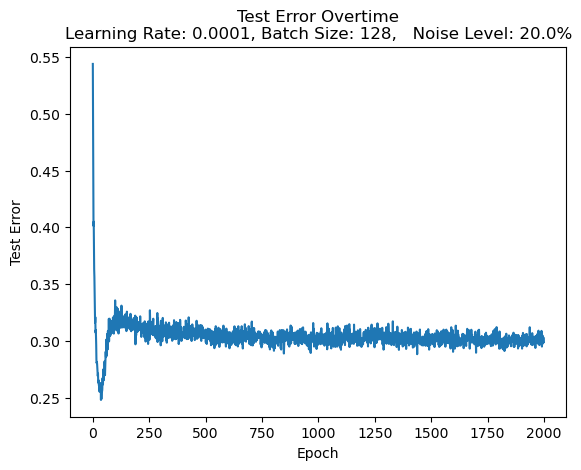

In [ ]:
epochs = list(range(0, 2000))
plt.plot(epochs, 1-df[model_names[2]])
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title(f'Test Error Overtime\nLearning Rate: {lr}, Batch Size: {batch_size},   Noise Level: {100*noise_levels[-1]}%')
plt.show()

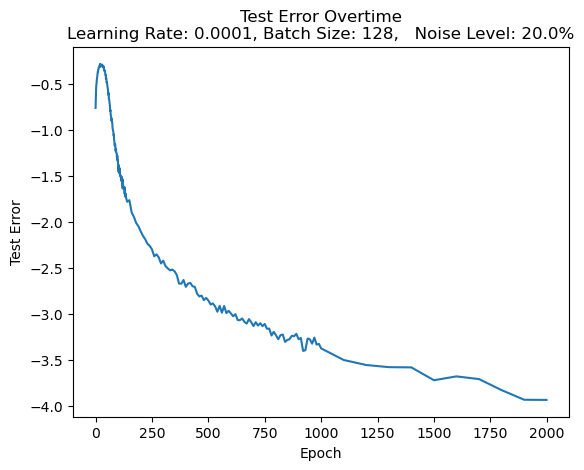

In [ ]:
epochs = list(range(0, 2000))
noisy_test_15 = pd.read_csv('/Users/sienkadounia/lab/ai-futures/Project/ewdd/noise_15checkpoint-with-noisenoisy_test_losses_with_label_noise.csv').values
plt.plot(to_save, 1-noisy_test_15)
plt.xlabel('Epoch')
plt.ylabel('Test Error')
plt.title(f'Test Error Overtime\nLearning Rate: {lr}, Batch Size: {batch_size},   Noise Level: {100*noise_levels[-1]}%')
plt.show()

In [ ]:
print("Started training for model width {model_width} on", device)

resnet_test_losses = []
resnet_train_losses = []
resnet_train_accs = []
resnet_test_accs = []

step = 0

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    resnet_train_loss = 0.0
    resnet_train_acc = 0.0

    for i, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      resnet_train_acc += torch.sum(predictions == labels).item()
      resnet_train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    resnet_train_loss /= len(trainloader)
    resnet_train_acc /= len(trainloader.dataset.data)
    resnet_train_losses.append(resnet_train_loss)
    resnet_train_accs.append(resnet_train_acc)

    # Validation (or test) loop
    model.eval()

    resnet_test_loss = 0.0
    resnet_test_acc = 0.0

    with torch.no_grad():
        for j, test_data in enumerate(testloader):
            test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_images)
            batch_test_loss = criterion(outputs, test_labels)
            resnet_test_loss += batch_test_loss.item()

            predictions = outputs.argmax(axis=-1)
            resnet_test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    resnet_test_loss /= len(testloader)
    resnet_test_acc /= len(testloader.dataset.data)
    resnet_test_losses.append(resnet_test_loss)
    resnet_test_accs.append(resnet_test_acc)

    wandb.log({'epoch': epoch,
               'loss/train': resnet_train_loss,
               'loss/test': resnet_test_loss,
               'accuracy/train': resnet_train_acc,
               'accuracy/test': resnet_test_acc
           }, step=step)

    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {resnet_train_loss:.4f}, Test Loss: {resnet_test_loss:.4f}')

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict()
      }

      prefix = 'checkpoint' if not use_label_noise else'checkpoint-with-noise'
      FILENAME = prefix+str(epoch)+'.pth'
      Path = f'/content/gdrive/My Drive/{FILENAME}'
      torch.save(checkpoint, '/Users/sienkadounia/lab/ai-futures/Project/normal/'+FILENAME) if not on_colab else torch.save(checkpoint, Path)
wandb.finish()

resnet_trl = np.array(resnet_train_losses)
resnet_tel = np.array(resnet_test_losses)
resnet_trac = np.array(resnet_train_accs)
resnet_teac = np.array(resnet_test_accs)
resnet_trl = pd.DataFrame(resnet_trl)
resnet_tel = pd.DataFrame(resnet_tel)
resnet_teac = pd.DataFrame(resnet_teac)
resnet_trac = pd.DataFrame(resnet_trac)
resnet_trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "clean_train_losses.csv", index=False) if not use_label_noise else resnet_trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "train_losses_with_label_noise.csv", index=False)
resnet_tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "clean_test_losses.csv", index=False) if not use_label_noise else resnet_tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "test_losses_with_label_noise.csv", index=False)
resnet_teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/'+ "clean_test_accs.csv", index=False) if not use_label_noise else resnet_teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "test_accs_with_label_noise.csv", index=False)
resnet_trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/'+ "clean_train_accs.csv", index=False) if not use_label_noise else resnet_trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/normal/' + "train_accs_with_label_noise.csv", index=False)

In [ ]:
if model_seed is not None:
    torch.manual_seed(model_seed)

resnet = make_resnet18k(model_width, num_classes)
resnet.to(device)
print(resnet.parameters)
print(f"The number of parameters is: {count_parameters(resnet)}")

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean').to(device)
model = resnet if not pytorch_default_resnet else resnet_pytorch
model.to(device)
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
dl = trainloader #if not use_label_noise else new_dataloader
count_parameters(model) # Cross-checking the model is the right one

In [ ]:
epochs = 1500

In [ ]:
wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': model_width,
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

wandb.watch(resnet)
config = wandb.config

In [ ]:
print("Started training for model width {model_width} on", device)

test_losses = []
train_losses = []
train_accs = []
test_accs = []

step = 0

for epoch in range(epochs):
  model.train()  # Set the model to training mode
  train_loss = 0.0
  train_acc = 0.0

  for i, data in enumerate(dl):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    batch_loss = criterion(outputs, labels)

    predictions = outputs.argmax(axis=-1)
    train_acc += torch.sum(predictions == labels).item()
    train_loss += batch_loss.item()

    batch_loss.backward()
    optimizer.step()

    step += 1

    wandb.log({'batch_loss': batch_loss.item()}, step=step)

  # Calculate average training loss for the epoch
  train_loss /= len(trainloader)
  train_acc /= len(trainloader.dataset.data)
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # Validation (or test) loop
  model.eval()

  test_loss = 0.0
  test_acc = 0.0

  with torch.no_grad():
      for j, test_data in enumerate(testloader):
          test_images, test_labels = test_data
          test_images = test_images.to(device)
          test_labels = test_labels.to(device)

          outputs = model(test_images)
          batch_test_loss = criterion(outputs, test_labels)
          test_loss += batch_test_loss.item()

          predictions = outputs.argmax(axis=-1)
          test_acc += torch.sum(predictions == test_labels).item()

  # Let's calculate average test loss for the epoch
  test_loss /= len(testloader)
  test_acc /= len(testloader.dataset.data)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

  wandb.log({'epoch': epoch,
              'loss/train': train_loss,
              'loss/test': test_loss,
              'accuracy/train': train_acc,
              'accuracy/test': test_acc
          }, step=step)

  # Print or log the training and test losses for each epoch
  print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

prefix = 'model' + '_width64'
FILENAME = prefix +'.pth' if not use_label_noise else prefix + '_with_noise.pth'
Path = f'/content/gdrive/My Drive/{FILENAME}'

torch.save(model.state_dict(), FILENAME) if not on_colab else torch.save(model.state_dict(), Path) 
wandb.finish()

trl = np.array(train_losses)
tel = np.array(test_losses)
trac = np.array(train_accs)
teac = np.array(test_accs)
trl = pd.DataFrame(trl)
tel = pd.DataFrame(tel)
teac = pd.DataFrame(teac)
trac = pd.DataFrame(trac)
trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/'+ prefix + "clean_train_losses.csv", index=False) if not use_label_noise else resnet_trl.to_csv('/Users/sienkadounia/lab/ai-futures/Project/' + prefix + "train_losses_with_label_noise.csv", index=False)
tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/'+ prefix + "clean_test_losses.csv", index=False) if not use_label_noise else resnet_tel.to_csv('/Users/sienkadounia/lab/ai-futures/Project/' + prefix + "test_losses_with_label_noise.csv", index=False)
teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/'+ prefix + "clean_test_accs.csv", index=False) if not use_label_noise else resnet_teac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/' + prefix + "test_accs_with_label_noise.csv", index=False)
trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/'+ prefix + "clean_train_accs.csv", index=False) if not use_label_noise else resnet_trac.to_csv('/Users/sienkadounia/lab/ai-futures/Project/'+ prefix + "train_accs_with_label_noise.csv", index=False)

In [ ]:
wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': model_width,
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

wandb.watch(resnet)
config = wandb.config

In [ ]:
print("Training on", device)

test_losses = []
train_losses = []
train_accs = []
test_accs = []

step = 0

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      train_acc += torch.sum(predictions == labels).item()
      train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    train_loss /= len(trainloader)
    train_acc /= len(trainloader.dataset.data)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation (or test) loop
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for j, test_data in enumerate(testloader):
            test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_images)
            batch_test_loss = criterion(outputs, test_labels)
            test_loss += batch_test_loss.item()

            predictions = outputs.argmax(axis=-1)
            test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    test_loss /= len(testloader)
    test_acc /= len(testloader.dataset.data)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    wandb.log({'epoch': epoch,
               'loss/train': train_loss,
               'loss/test': test_loss,
               'accuracy/train': train_acc,
               'accuracy/test': test_acc
           }, step=step)

    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict()
      }

      prefix = 'checkpoint' if not use_label_noise else'checkpoint-with-noise'
      FILENAME = prefix+str(epoch)+'.pth'
      Path = f'/content/gdrive/My Drive/{FILENAME}'
      torch.save(checkpoint, '/Users/sienkadounia/lab/ai-futures/Project/normal'+FILENAME) if not on_colab else torch.save(checkpoint, Path)
wandb.finish()

In [ ]:
final_checkpoint = {
  'epoch': epoch,
  'model_state': model.state_dict(),
  'optim_state': optimizer.state_dict()
}

prefixf = 'final_checkpoint' if not use_label_noise else'final_checkpoint-with-noise'
FINAL_FILENAME = prefixf+'.pth'
Path = f'/content/gdrive/My Drive/{FINAL_FILENAME}'
torch.save(final_checkpoint, FINAL_FILENAME) if not on_colab else torch.save(final_checkpoint, Path)

In [ ]:
# Plot the training and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
trl = np.array(train_losses)
tel = np.array(test_losses)
teac = np.array(test_accs)
trl = pd.DataFrame(trl)
tel = pd.DataFrame(tel)
teac = pd.DataFrame(teac)
trl.to_csv("clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv("train_losses_with_label_noise.csv", index=False)
tel.to_csv("clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv("test_losses_with_label_noise.csv", index=False)
teac.to_csv("clean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv("test_accs_with_label_noise.csv", index=False)

# Estimating the Learning Coefficients (RLCTs)

In [ ]:
import seaborn
import yaml
import devinterp
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace

In [ ]:
last_checkpoint = torch.load('final_checkpoint_with_noise.pth')

In [ ]:
model = resnet if not pytorch_default_resnet else resnet_pytorch
optimizer = optimizer

In [ ]:
model.load_state_dict(last_checkpoint['model_state'])
optimizer.load_state_dict(last_checkpoint['optim_state'])

In [ ]:
model.state_dict()

In [ ]:
optimizer.state_dict()

In [ ]:
torch.manual_seed(0)

final_rlcts = estimate_learning_coeff_with_summary(
    model,
    loader=trainloader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
    num_chains=5,  # How many independent chains to run
    num_draws=256,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=device,
)

In [ ]:
pref = 'sgd_' if not use_adam_op else 'adam_'
rlcts_final = pref + 'final_model_rlcts.pt' if not use_label_noise else pref + 'final_model_with_noise_rlcts.pt'
torch.save(final_rlcts, rlcts_final)

In [ ]:
trace = final_rlcts.pop("loss/trace")

print("Lambda hat estimates: ")
print(yaml.dump(final_rlcts))

In [ ]:
plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

In [ ]:
original_checkpoint = 'adam_checkpoint_with_noise'
name = 'sgd_checkpoint' if not use_adam_op else 'adam_checkpoint'
next = 100
for i in range(14):
    if i == 0:
            checkpoint_name = original_checkpoint + str(10) + '.pth'
            right_name = name + str(10)
            checkpoint = torch.load(checkpoint_name)
            model.load_state_dict(checkpoint['model_state'])

            torch.manual_seed(0)
            checkpoint_rlcts = estimate_learning_coeff_with_summary(
                model,
                loader=trainloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
                num_chains=5,  # How many independent chains to run
                num_draws=256,  # How many samples to draw per chain
                num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,  # How many steps to take between each sample
                device=device,
            )

            
            current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
            torch.save(checkpoint_rlcts, current_checkpoint)

            trace = checkpoint_rlcts.pop("loss/trace")

            print(f"Lambda hat estimates for {right_name}: ")
            print(yaml.dump(checkpoint_rlcts))
            plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

    else:
        checkpoint_name = original_checkpoint + str(next) + '.pth'
        right_name = name + str(next)
        checkpoint = torch.load(checkpoint_name)
        model.load_state_dict(checkpoint['model_state'])

        torch.manual_seed(0)
        checkpoint_rlcts = estimate_learning_coeff_with_summary(
            model,
            loader=trainloader,
            criterion=criterion,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
            num_chains=5,
            num_draws=256,
            num_burnin_steps=0,
            num_steps_bw_draws=1, 
            device=device,
        )

        current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
        torch.save(checkpoint_rlcts, current_checkpoint)

        trace = checkpoint_rlcts.pop("loss/trace")

        print(f"Lambda hat estimates for {right_name}: ")
        print(yaml.dump(checkpoint_rlcts))
        plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
        
        next += 100

In [176]:
torch.manual_seed(0)

final_rlcts = estimate_learning_coeff_with_summary(
    model,
    loader=trainloader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
    num_chains=5,  # How many independent chains to run
    num_draws=256,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=device,
)

Chain 4: 100%|██████████| 256/256 [00:20<00:00, 12.61it/s]


In [177]:
pref = 'sgd_' if not use_adam_op else 'adam_'
rlcts_final = pref + 'final_model_rlcts.pt' if not use_label_noise else pref + 'final_model_with_noise_rlcts.pt'
torch.save(final_rlcts, rlcts_final)

In [178]:
trace = final_rlcts.pop("loss/trace")

print("Lambda hat estimates: ")
print(yaml.dump(final_rlcts))

Lambda hat estimates: 
llc-chain/0: 13476.9853515625
llc-chain/1: 13649.435546875
llc-chain/2: 13329.927734375
llc-chain/3: 13573.5380859375
llc-chain/4: 13495.455078125
llc/mean: 13505.0693359375
llc/std: 119.462646484375



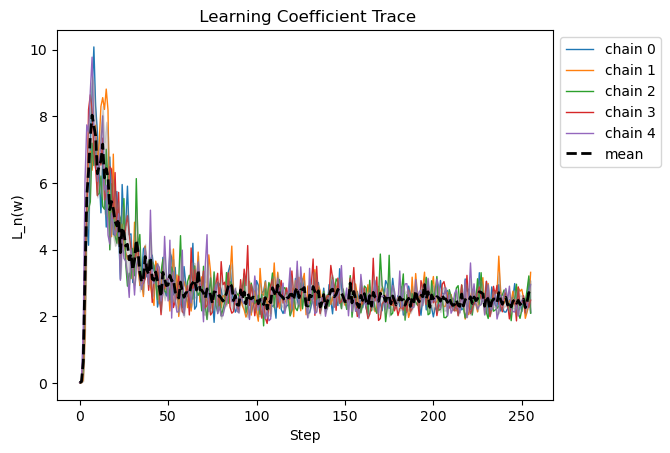

<Figure size 1200x900 with 0 Axes>

In [179]:
plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

Chain 4: 100%|██████████| 256/256 [00:19<00:00, 13.47it/s]


Lambda hat estimates for adam_checkpoint10: 
llc-chain/0: 7800.19921875
llc-chain/1: 7927.599609375
llc-chain/2: 7994.4111328125
llc-chain/3: 7789.58154296875
llc-chain/4: 8234.2666015625
llc/mean: 7949.2119140625
llc/std: 181.2821502685547



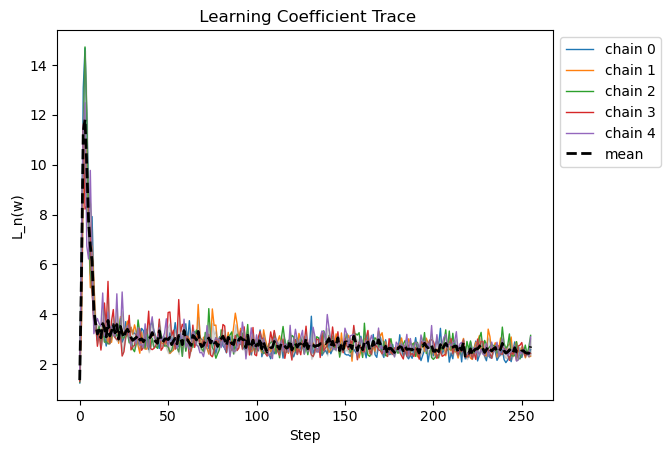

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [00:18<00:00, 13.51it/s]


Lambda hat estimates for adam_checkpoint100: 
llc-chain/0: 12515.35546875
llc-chain/1: 12730.9375
llc-chain/2: 12379.6376953125
llc-chain/3: 12427.1572265625
llc-chain/4: 12789.564453125
llc/mean: 12568.5302734375
llc/std: 182.8431854248047



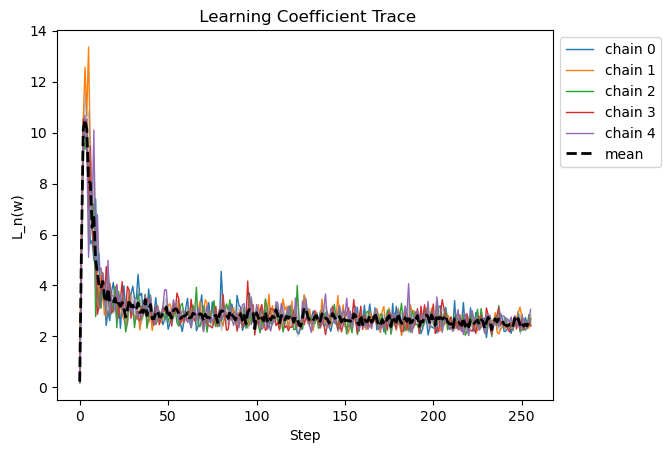

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [00:19<00:00, 13.23it/s]


Lambda hat estimates for adam_checkpoint200: 
llc-chain/0: 12832.5810546875
llc-chain/1: 12626.833984375
llc-chain/2: 12898.103515625
llc-chain/3: 13003.3779296875
llc-chain/4: 13211.2080078125
llc/mean: 12914.4208984375
llc/std: 215.4449920654297



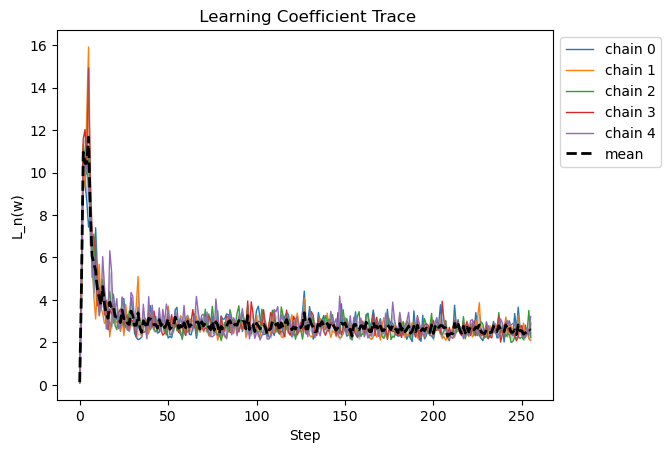

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [19:55<00:00,  4.67s/it]


Lambda hat estimates for adam_checkpoint300: 
llc-chain/0: 13409.8896484375
llc-chain/1: 13341.83984375
llc-chain/2: 14072.1611328125
llc-chain/3: 13292.4521484375
llc-chain/4: 13420.53125
llc/mean: 13507.375
llc/std: 320.00872802734375



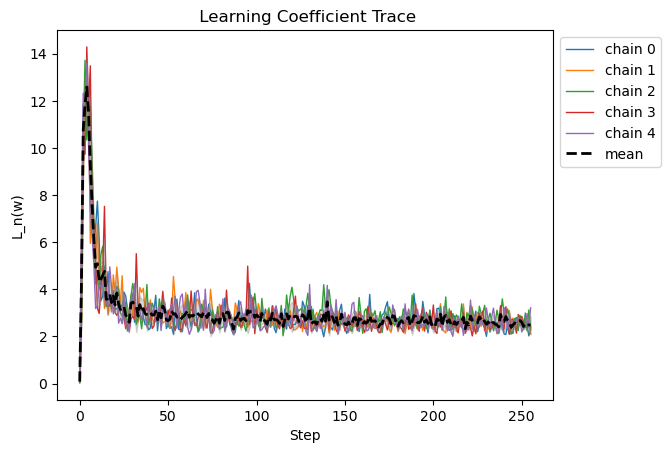

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:40:57<00:00, 23.66s/it]


Lambda hat estimates for adam_checkpoint400: 
llc-chain/0: 13125.974609375
llc-chain/1: 13192.3115234375
llc-chain/2: 13649.458984375
llc-chain/3: 13388.4365234375
llc-chain/4: 13450.939453125
llc/mean: 13361.4248046875
llc/std: 209.60813903808594



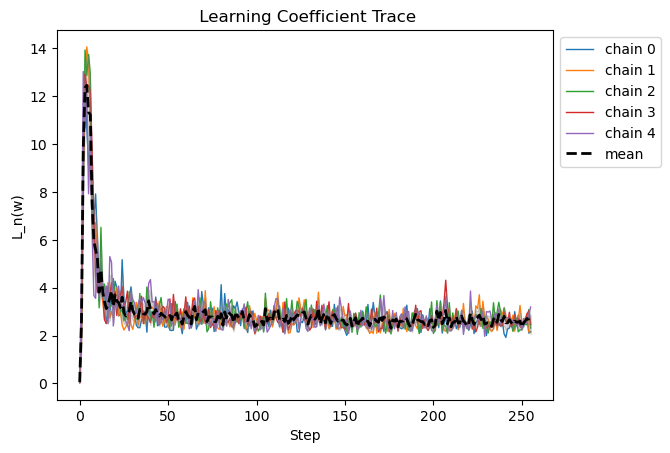

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:51:52<00:00, 26.22s/it]   


Lambda hat estimates for adam_checkpoint500: 
llc-chain/0: 13851.7138671875
llc-chain/1: 13570.240234375
llc-chain/2: 13869.775390625
llc-chain/3: 13969.314453125
llc-chain/4: 14247.599609375
llc/mean: 13901.728515625
llc/std: 243.72198486328125



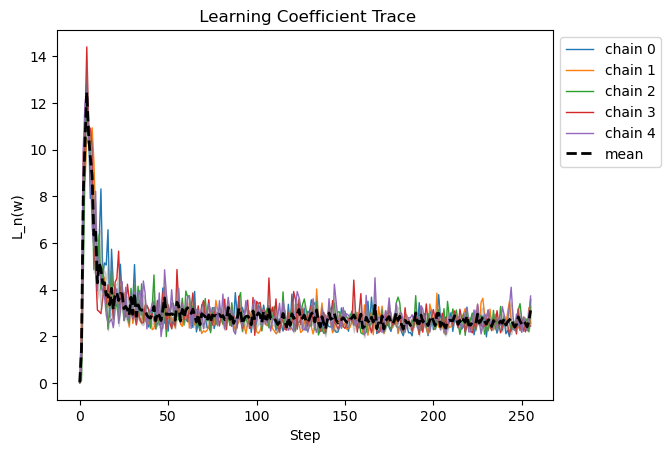

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:58:22<00:00, 27.75s/it]


Lambda hat estimates for adam_checkpoint600: 
llc-chain/0: 13384.0478515625
llc-chain/1: 13715.07421875
llc-chain/2: 14123.43359375
llc-chain/3: 13763.2490234375
llc-chain/4: 13523.67578125
llc/mean: 13701.8974609375
llc/std: 280.3666076660156



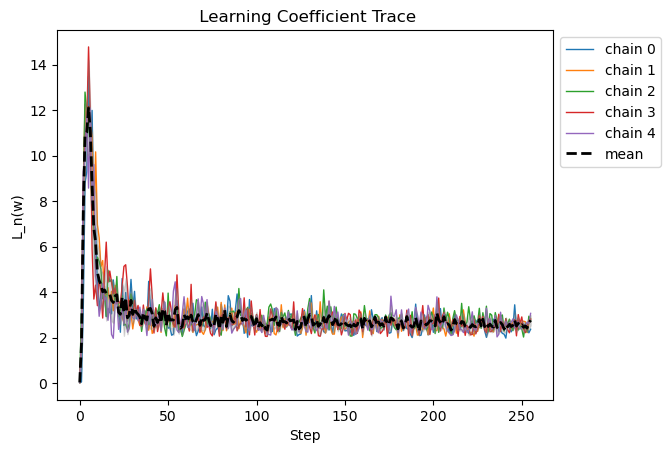

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:36:30<00:00, 22.62s/it]


Lambda hat estimates for adam_checkpoint700: 
llc-chain/0: 13592.3017578125
llc-chain/1: 14149.29296875
llc-chain/2: 13858.65625
llc-chain/3: 14013.9453125
llc-chain/4: 13656.3046875
llc/mean: 13854.1005859375
llc/std: 234.7187042236328



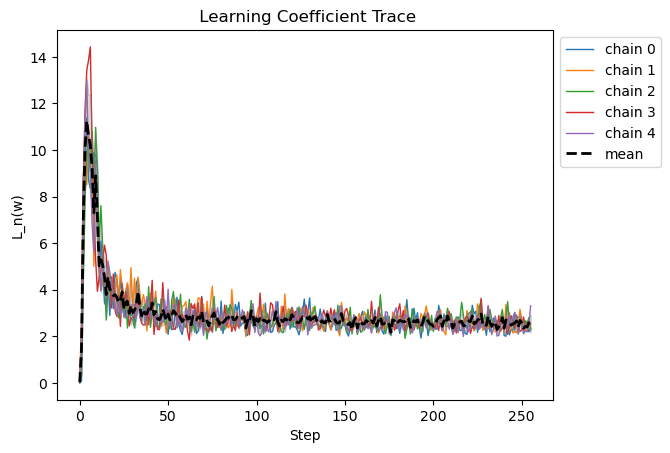

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [12:01:38<00:00, 169.14s/it]   


Lambda hat estimates for adam_checkpoint800: 
llc-chain/0: 13965.072265625
llc-chain/1: 13622.3134765625
llc-chain/2: 13522.486328125
llc-chain/3: 13499.47265625
llc-chain/4: 14288.91015625
llc/mean: 13779.650390625
llc/std: 340.2626037597656



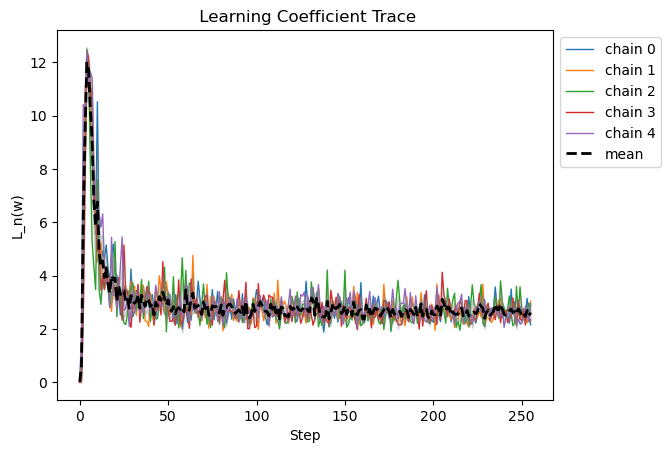

<Figure size 1200x900 with 0 Axes>

Chain 0:  50%|█████     | 129/256 [1:09:02<1:07:58, 32.11s/it]


KeyboardInterrupt: 

In [180]:
original_checkpoint = 'adam_checkpoint_with_noise'
name = 'sgd_checkpoint' if not use_adam_op else 'adam_checkpoint'
next = 100
for i in range(14):
    if i == 0:
            checkpoint_name = original_checkpoint + str(10) + '.pth'
            right_name = name + str(10)
            checkpoint = torch.load(checkpoint_name)
            model.load_state_dict(checkpoint['model_state'])

            torch.manual_seed(0)
            checkpoint_rlcts = estimate_learning_coeff_with_summary(
                model,
                loader=trainloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
                num_chains=5,  # How many independent chains to run
                num_draws=256,  # How many samples to draw per chain
                num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,  # How many steps to take between each sample
                device=device,
            )

            
            current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
            torch.save(checkpoint_rlcts, current_checkpoint)

            trace = checkpoint_rlcts.pop("loss/trace")

            print(f"Lambda hat estimates for {right_name}: ")
            print(yaml.dump(checkpoint_rlcts))
            plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

    else:
        checkpoint_name = original_checkpoint + str(next) + '.pth'
        right_name = name + str(next)
        checkpoint = torch.load(checkpoint_name)
        model.load_state_dict(checkpoint['model_state'])

        torch.manual_seed(0)
        checkpoint_rlcts = estimate_learning_coeff_with_summary(
            model,
            loader=trainloader,
            criterion=criterion,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
            num_chains=5,
            num_draws=256,
            num_burnin_steps=0,
            num_steps_bw_draws=1, 
            device=device,
        )

        current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
        torch.save(checkpoint_rlcts, current_checkpoint)

        trace = checkpoint_rlcts.pop("loss/trace")

        print(f"Lambda hat estimates for {right_name}: ")
        print(yaml.dump(checkpoint_rlcts))
        plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
        
        next += 100